
# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


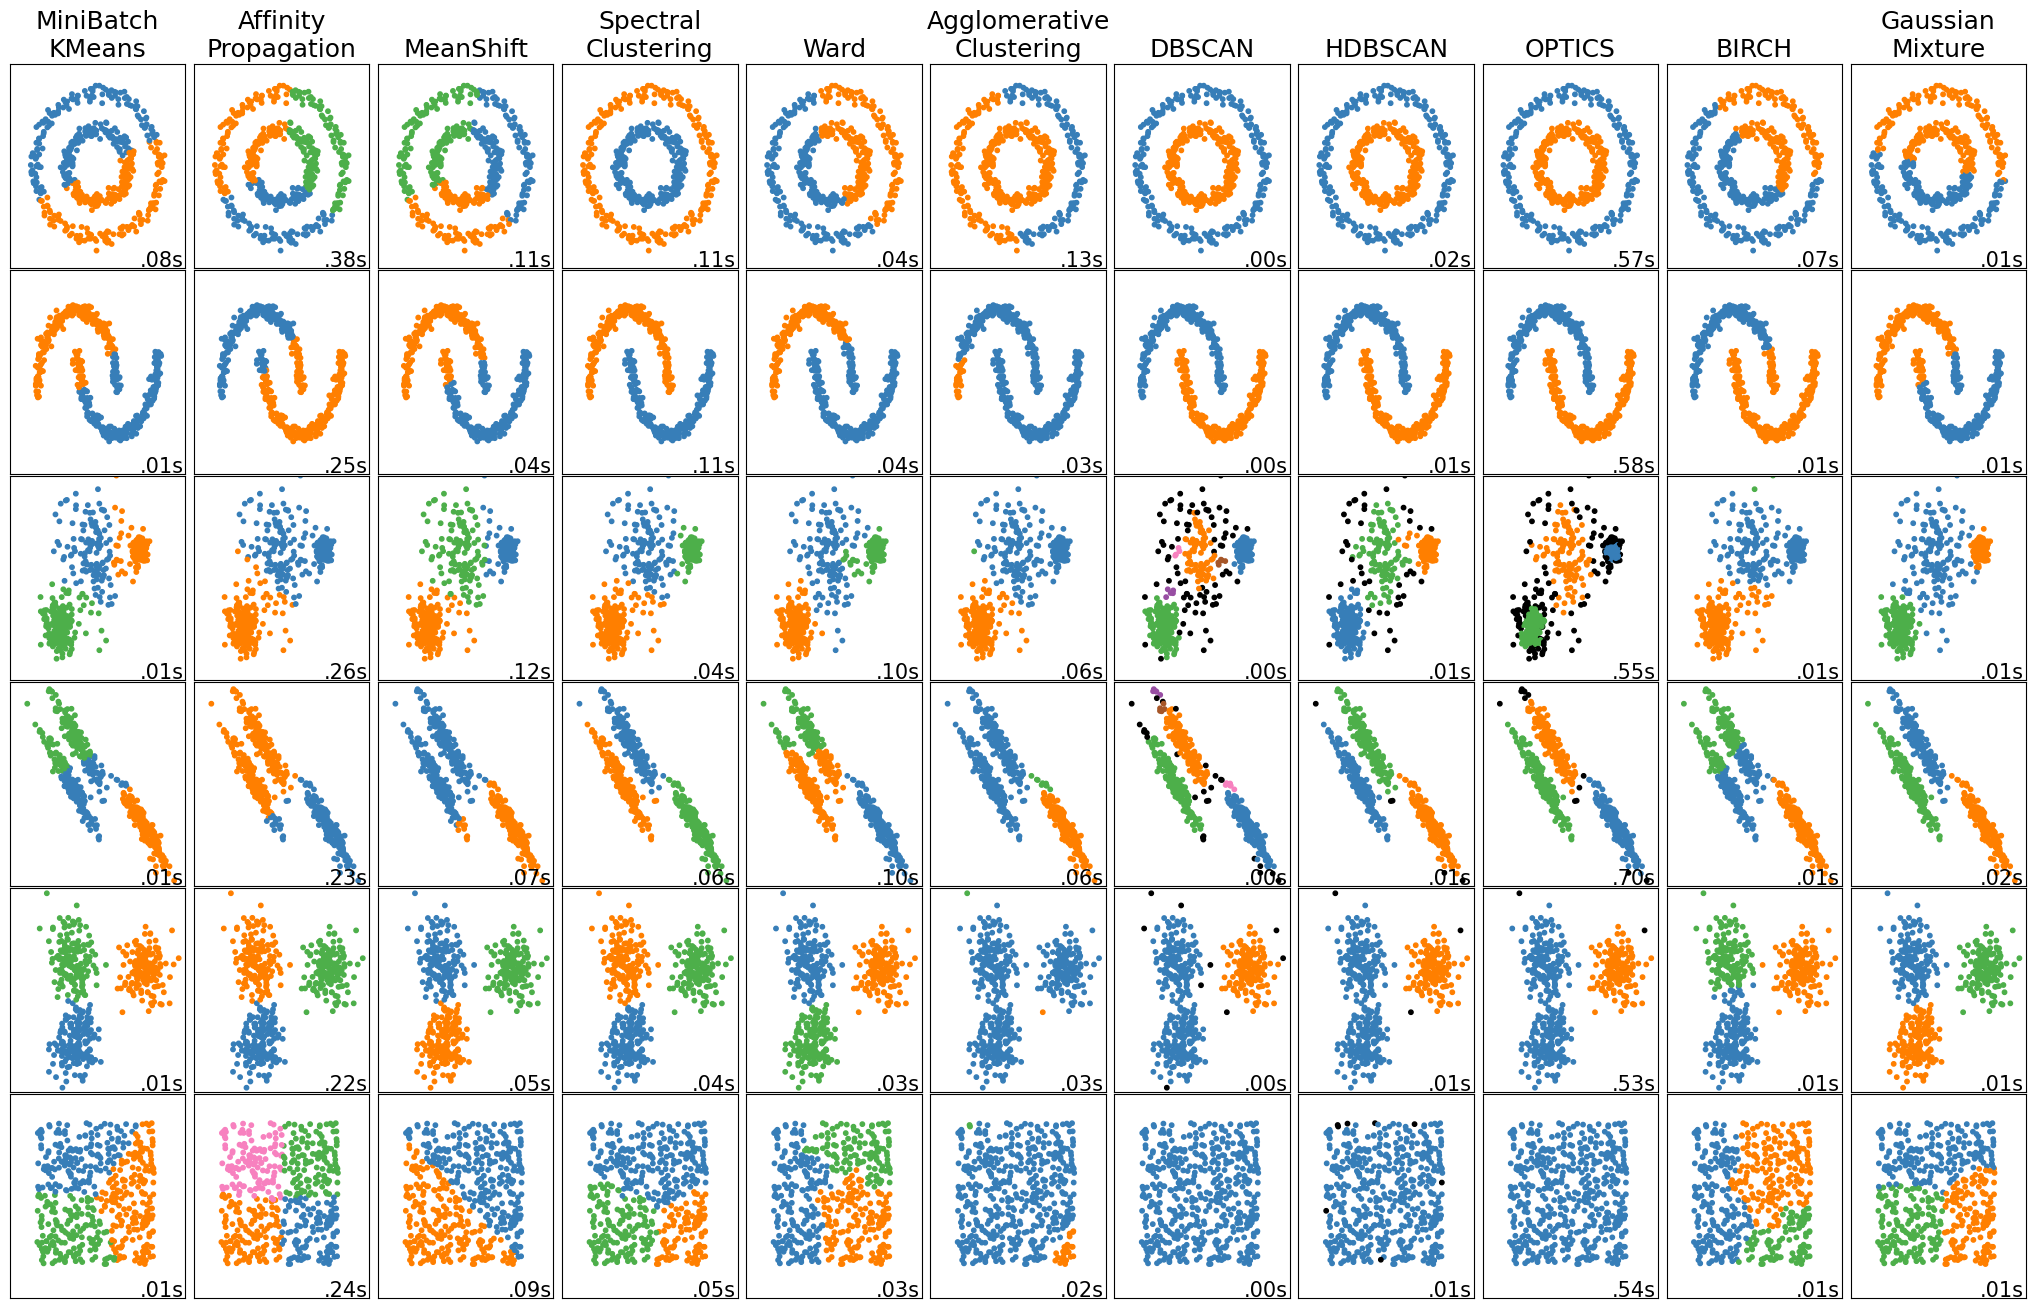

In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                "connectivity matrix is [0-9]{1,2}"
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1
plt.savefig("cluster_comparison.png")
plt.show()

In [2]:
# let's save our plot
# plt.savefig("cluster_comparison.png")

## Irises clustering

In [17]:
import sklearn # the example code above overwrote the original datasets so we need to import datasets again,
# to avoid name collissions I will just import sklearn fully

In [4]:
# let's load irises dataset from sklearn
irises = sklearn.datasets.load_iris(as_frame = True)
print(f"Shape of data: {irises.data.shape}")
print(f"Shape of target: {irises.target.shape}")

Shape of data: (150, 4)
Shape of target: (150,)


In [5]:
irises.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
# answers / ground truth
irises.target.head()

,target
0,0
1,0
2,0
3,0
4,0


In [7]:
irises.target.tail()

,target
145,2
146,2
147,2
148,2
149,2


In [8]:
# irises description
print(irises.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [9]:
# let's use kmeans to segment our data into 3 segments
# first we get specific model
kmeans = sklearn.cluster.KMeans(n_clusters = 3)
# next we actually fit / create model for clustering
kmeans.fit(irises.data)
# finally we use it to predict labels, in this case for the same data - that is fine
predictions = kmeans.predict(irises.data)
# predictions head, and tail
predictions[:10], predictions[-10:]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32))

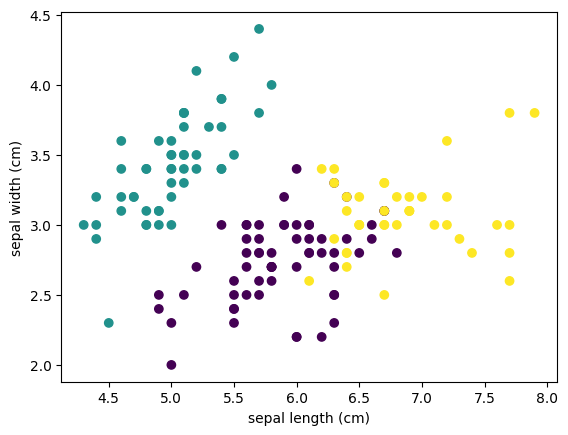

In [10]:
# let's plot our first two features with color as predictions
# matplotlib just assigns color based on value in predictions
plt.scatter(irises.data.iloc[:, 0], irises.data.iloc[:, 1], c = predictions)
# let's add x and y labels - double check irises.DESCR
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.show()

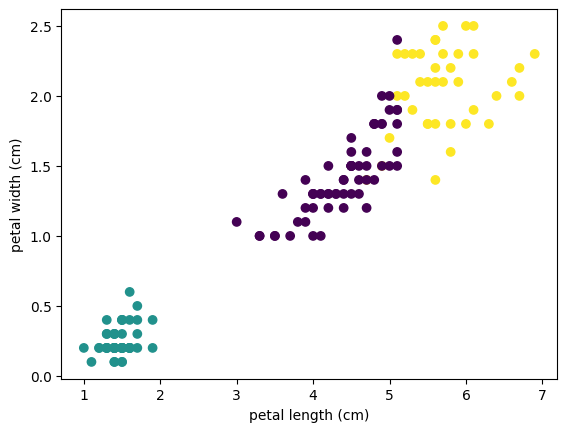

In [11]:
# now let's plot petals with colors from segmentation
plt.scatter(irises.data.iloc[:, 2], irises.data.iloc[:, 3], c = predictions)
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.show()
#

## Spectral clustering

In [12]:
# let's try to fit a spectral clustering model, we still need to supply number of clusters
spectral_model = sklearn.cluster.SpectralClustering(n_clusters = 3)
# let's train the model
spectral_model.fit(irises.data)
# now get predictions as spectral_predictions
spectral_predictions = spectral_model.fit_predict(irises.data)

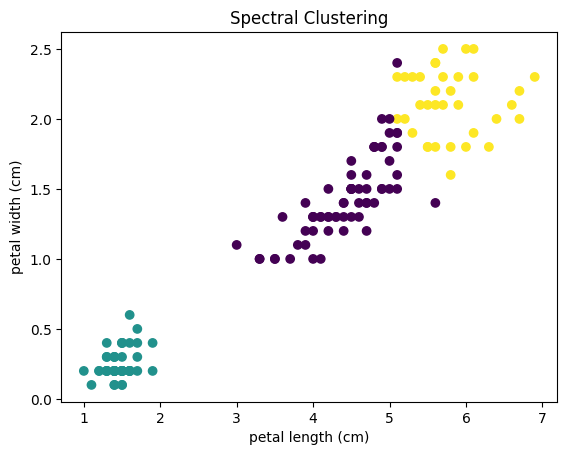

In [13]:
# let's plot petals again using spectral_predictions as color
plt.scatter(irises.data.iloc[:, 2], irises.data.iloc[:, 3], c = spectral_predictions)
plt.title("Spectral Clustering")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.show()

In [14]:
irises.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [15]:
# let's create a 3D plot using plotly for petal length, width and sepal length, using spectral_predictions for color
import plotly.express as px
# TODO FIXME legend labels!!!
fig = px.scatter_3d(irises.data, x = "sepal length (cm)", y = "sepal width (cm)", z = "petal length (cm)", color = spectral_predictions)
fig.show()

In [16]:
## Elbow method for optimal number of clusters
# fro k-means if we do not know the number of clusters beforhand that is what value for k to give
# we can plot some centrality value for different k

# let's calculate some centrality for k values from 2 to 10
# the look for elbow
# https://en.wikipedia.org/wiki/Elbow_method_(clustering)

## Inertia explanation

### Summary
In **KMeans (scikit-learn)**, **inertia** measures how compact the clusters are.  
It is defined as the **sum of squared distances from each data point to the centroid of the cluster it belongs to**.

Lower inertia means points are, on average, closer to their assigned centroids.  
Inertia always decreases as the number of clusters increases, so it must be interpreted **comparatively**, not in isolation.

---

### Intuitive interpretation
Think of inertia as **total within-cluster “spread”**:

- Each data point is pulled toward its cluster center
- The farther points are from their centroid, the larger the inertia
- Tight, compact clusters → low inertia  
- Loose, scattered clusters → high inertia

Important:
- Inertia does **not** tell you whether clusters are meaningful
- It only measures geometric compactness in feature space

---

### Mathematical definition
Given:
- $x_i$ — a data point  
- $\mu_{c(i)}$ — centroid of the cluster assigned to $x_i$


The inertia is:

$\text{inertia} = \sum_{i=1}^{n} \| x_i - \mu_{c(i)} \|^2$



KMeans in scikit-learn uses **squared Euclidean distance**.

After fitting a model, inertia is available as:

```python
kmeans.inertia_
```


## Elbow curve example on irises data set

Calculate and plot the KMeans inertia for `irises.data` for `k` values ranging from 2 to 10, to create an elbow curve.

## Calculate KMeans inertia for k from 2 to 10

### Subtask:
Iterate through potential numbers of clusters (k from 2 to 10). For each k, initialize a KMeans model, fit it to `irises.data`, and record its inertia (sum of squared distances of samples to their closest cluster center).


**Reasoning**:
To calculate the KMeans inertia for different values of k, I will initialize an empty list, loop from k=2 to k=10, create a KMeans model for each k, fit it to the `irises.data`, and store the model's inertia in the list.



In [18]:
inertia_values = []
for k in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(irises.data)
    inertia_values.append(kmeans.inertia_)
print("Inertia values for k from 2 to 10:", inertia_values)

Inertia values for k from 2 to 10: [152.34795176035797, 78.85566582597727, 57.350880212954756, 46.47223015873018, 39.066035353535376, 34.305815295815314, 30.476222943722966, 29.906246659137977, 28.545297810033116]


**Reasoning**:
Now that the KMeans inertia values have been calculated for different k values, the next step is to plot these values to visualize the elbow curve. This will help in determining the optimal number of clusters.



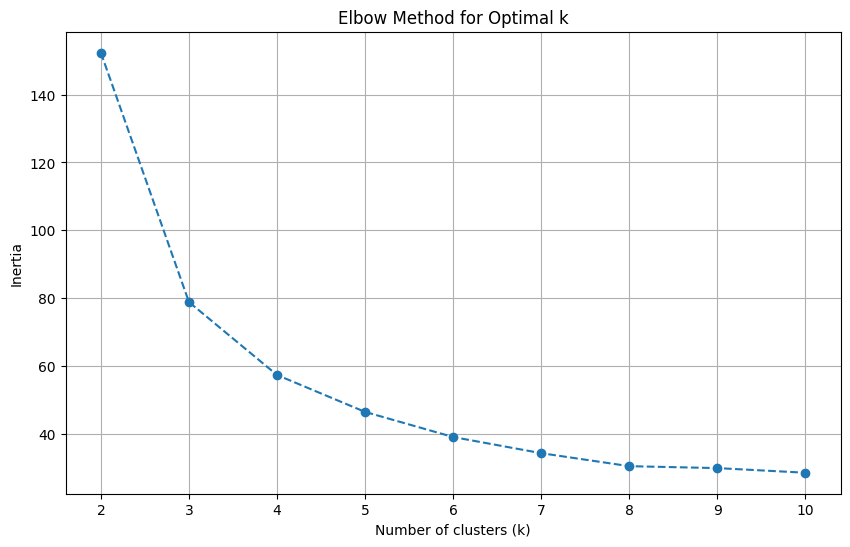

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


## Summary:

### Data Analysis Key Findings

*   KMeans inertia values were successfully calculated for `k` ranging from 2 to 10 on the `irises.data` dataset.
*   The calculated inertia values are:
    *   `k=2`: 152.35
    *   `k=3`: 78.86
    *   `k=4`: 57.35
    *   `k=5`: 46.47
    *   `k=6`: 39.07
    *   `k=7`: 34.31
    *   `k=8`: 30.48
    *   `k=9`: 29.91
    *   `k=10`: 28.55
*   The inertia consistently decreases as the number of clusters (`k`) increases, which is an expected behavior as more clusters generally lead to smaller within-cluster sum of squares.
*   An elbow curve plot was generated, visually representing the relationship between the number of clusters and the inertia.

### Insights or Next Steps

*   The elbow curve indicates a significant drop in inertia between `k=2` and `k=3`, and a less pronounced but still noticeable decrease between `k=3` and `k=4`. This suggests that the optimal number of clusters might be around 3 or 4, where the rate of decrease in inertia starts to slow down considerably, forming an "elbow" in the plot.
*   Further analysis of the elbow plot, particularly focusing on the point where the rate of decrease in inertia changes most significantly, should be performed to determine the optimal number of clusters for the `irises.data` dataset.
